In [2]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'sky', u'transition': 'zoom'}

#Tensor networks:  applications and algorithms
#####Ivan Oseledets, Skolkovo Institute of Science and Technology 
##### oseledets.github.io, i.oseledets@skoltech.ru

## Skoltech
- Founded in 2011 as a new Western-style university near Moscow http://faculty.skoltech.ru
- In collaboration with MIT
- No departments: priority areas "IT, Bio, Space and Nuclear"
- At the moment, 160 master students, 30 professors, 40 postdocs, 50 PhD studens 

In [15]:
%reload_ext tikzmagic

## Talk outline
The main goal is to show, that tensor networks are around in different communities, sharing **similar algorithms** but different applications.

- What is a tensor and motivation for working with them
- Superposition of functions and sum-product networks (+their learning)
- Tree tensor networks and numerical linear algebra
- Optimization methods on manifolds

## What is a tensor
A tensor is a $d$-way array $A(i_1, \ldots, i_d)$.  

**It may take a lot of memory to store it!**

It may come from many different applications.

## Motivation 
<font size=6.5>
  Say we want to
- Denoize an image $X$;
- Generate a new image of a horse;
- Fill the gaps (image completion).  


To do it, we may build a probabilistic model of our images:  

  $$
  P: 256^{1000 \times 1000} \mapsto [0, 1]
  $$
  Now we can
- Find the image that is close to $X$ and have high probability;
- Generate new image from the distribution $P$;
- Find the most probable values of hidden pixels.




## Three dimensions
  Random variable $\vec{x} = (x_1, x_2, x_3)$, $x_j \in \{1, 2\}$:
- Estimate all 8 parameters from the data:

  $$
  P(\vec{x}) := \frac{1}{N} \sum_{i=1}^N [\vec{x} = \vec{x}^i]
  $$
 
- Just store it explicitly: $P \in \mathbb{R}^{2 \times 2 \times 2}$.
 
  **Million dimensions.**  
  
  How to estimate and store $256^{1000 000}$ parameters (probabilities)?


## Other examples where tensors arises
<font size=5.5>
- Data cubes (multivariate factor analysis)
- Discretization of a function $f(x_1, \ldots, x_d)$ on a tensor-product grid (multivariate function approximation)
- High-dimensional PDEs and fine grids (the idea of **quantization**)
- The index $(i_1, \ldots, i_d)$ can define **the state** of the system, and the element of the tensor -- **the probability** of being in such state
- Quantum spin systems (Schrodinger equation)
- Biochemical networks (chemical master equation)
- Hidden Markov Models
- Probabilistic context-free grammars (probabilities of the symbols)
- Weighted finite automata
- Classification problems (i.e., $(i_1, \ldots, i_d)$ is a **feature vector**)
- Markov random fields/Graphical models
- Deep learning 

## Different names, techniques and communities
<font size=6.0>
Many algorithms and methods are known in different communities:

- Numerical linear algebra/numerical analysis: tensor trains, H-Tucker, Tucker, canonical decomposition
- Solid state physics/quantum information: matrix product states/tensor networks, uniform MPS
- Statistical physics: tranfer matrices
- Markov random fields: belief propagation
- Hidden Markov Models: spectral methods, EM-algorithm
- Weighted finite automata
- Sum-product network

## Tensor formats
We need a tensor format (or multivariate function representation) that is:
- **Easy to evaluate** (inference).
- **Flexible** (i.e. the class of interesting tensors represented in this form is as large as possible)
- **Fast learning** (i.e. the structure and parameters can be recovered from the observed data in reasonable time)

## Idea: superposition of functions
A superposition of simple functions is easy to evaluate!
<font size=6.5>
**Kolmogorov superposition theorem**:

Every continious function from $[0, 1]^d \rightarrow \mathbb{R}$ can be written as a superposition of smaller-dimensional functions

$$f(x_1, \ldots, x_d) = \sum_{n=0}^{2d} g_n(\xi(x_1 + na, \ldots, x_d + na)), $$
$$\xi(x_1 + na, \ldots, x_d + na) = \sum_{i=1}^d \lambda_i \psi(x_i + na) $$

Not constructive, but more **instructive**: what we can only compute is the superposition of simple functions!

## Sum and products
<font size=6.7>
The simplest construction is the  combination  of **weighted sum** operation and **product operation**

Now we will follow the idea of Sum-product network (SPN) by [Hoifung Poon and Pedro Domingos](http://turing.cs.washington.edu/papers/uai11-poon.pdf)

We can start from **simple univariate functions** (or **distributions**), and the state the following axioms.

- Univariate functions (gaussian, polynomials...) are SPN.
- Product of SPN over disjoint sets is an SPN, i.e. $f(x_1, x_2) g(x_3, x_5)$.
- Sum over **the same variables** is an SPN, i.e. $\sum_{x_2} f(x_1, x_2) g(x_2, x_3)$

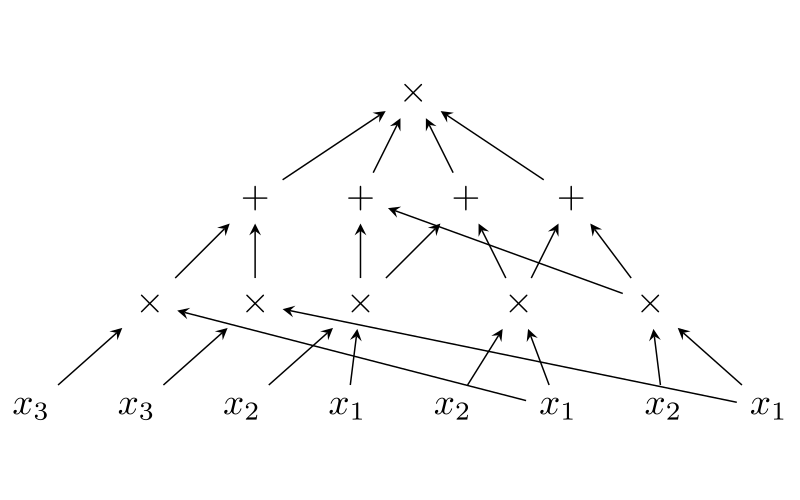

In [279]:
%%tikz -l graphdrawing,graphs,trees,automata,quotes -f svg -s 800,500 --save /Users/ivan/work/talks-online/eth-2015/spn.svg
\tikzset{>=stealth}
\usegdlibrary{layered,trees,circular,force}
\graph[grow=up,  layered layout]{
    q__"$\times$",
    s1__"$+$", s2__"$+$",s3__"$+$", s4__"$+$",
    p1__"$\times$",     p2__"$\times$", p3__"$\times$", p4__"$\times$", p5__"$\times$", 2__"$x_1$", 3__"$x_1$", 4__"$x_1$", 
    5__"$x_2$", 6__"$x_2$", 7__"$x_2$", 8__"$x_3$", 9__"$x_3$",
    2 -> {p1}, 3 -> {p2}, 4 -> {p3}, 5 -> {p1}, 6 -> {p2},  7 -> {p3}, 8 -> {p4}, 2 -> {p4}, 9 -> {p5}, 3 -> {p5}, 
    s1 <- {p1, p2}, s2 <- {p2, p3}, s3 <- {p1, p3},  s4 <- {p4, p5}, q <- {s1, s2, s3, s4}
};

## SPN as a tree
SPN can be visualized as a tree, with sum/product nodes combined in different ways.

<img src='spn.svg' width=80%>

Example of the SPN network for a function of three variables.

## Motivation behind "sum" nodes

If the we approximate the probability distribution, then there is a natural interpretation of the **sum nodes**:

It is **conditional independence**: you have two variables, and $P(x, y) \neq P_x(x) P_y(y)$.  

Assume that given certain hidden variable $z$ they are indepedent: 

$$P(x, y | z) = P_x(x | z) P_y( y | z),$$

thus $P(x, y)$ is just a sum of products over $z$.

## SPN meaning
Our input data is are the realizations of the $(x_1, \ldots, x_d)$ according to the probability distribution.

It is a table of size  $N_{\mathrm{samples}} \times d$.

The nodes have a simple meaning:

- Sum node gives **clusters** in the dataset
- Product node **independent sets of variables**.

## Idea of learning

There is a nice algorithm for learning SPN, which is based on the probability interpretation. 

1. Given samples from the probability distribution, establish approximate independence of two **groups of variables**.
2. If there is no independence for any two groups, group similar instances and represent the function as a sum (and learn SPN for each subset).

## Special cases of SPN
- Hierarchical Tucker decomposition (SPN is more general).
- Thin junction trees (Hidden Markov Model/Tensor train).

## Using SPN to approximate functions
But up to now it has been applied only for probability distributions!  

What if we are numerical analysts and 

**want to approximate a multidimensional function**?  


## Proposed solution
Provided that $f$ can be interpreted as a probability distribution,  

sample it using **Gibbs sampler**  (or Metropolis-Hastings), and then apply the SPN method to the samples.

This way we will be able to recover the network structure.

## Tensor network

Sum-product-network can be seen as a particular case of more general **tensor formats**, represented by graphs.

## Mathematical definition of a tensor network

- Given a graph, we associate **original indices** with the vertices, and **auxiliary indices** with the **edges**.

- In each vertex we store a **tensor** that depends on the index in the **vertex** and in all **edges**.

- We multiply these tensors and sum over all edges:  


   $$A(i_1, \ldots, i_d) = \sum_{s(E)}\prod_V G(s(V)) $$

## Is it easy to work with a tensor network?

**The simplest task:** evaluate an element of the tensor. 

The more cycles the graph of your network has, the higher is the complexity!

## Tree Tensor Networks

A special case is the case of **tree tensor networks**.  

In this case, the evaluation of the element can be done by bottom-to-top tree traversal.

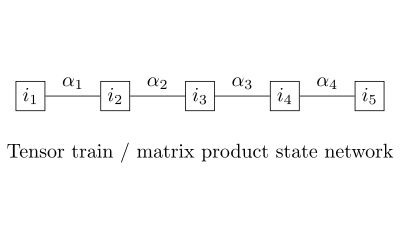

In [281]:
%%tikz -l graphdrawing,graphs,trees,automata,quotes -f svg --save /Users/ivan/work/talks-online/eth-2015/tt.svg
\tikzset{>=stealth}
\usegdlibrary{layered,trees,circular,force}
\graph[grow right=1.5cm, branch down]{
 {[nodes={rectangle, draw}] i1__$i_1$ -- ["$\alpha_1$"] i2__$i_2$ --  ["$\alpha_2$"] 
                           i3__$i_3$ -- ["$\alpha_3$"]  i4__$i_4$ -- ["$\alpha_4$"] i5__$i_5$}, 
    / -!- / -!- A__"Tensor train / matrix product state network" -!- i3;
   
  
};  

## Tensor-train / matrix product state "network"
<font size=6.5>
A specific case of the tree tensor network is the **tensor train** (or matrix product state) representatation, 

which can be written as

$$A(i_1, \ldots, i_d) = G_1(i_1) \ldots G_d(i_d),$$

i.e. the **product of matrices, depending only on 1 index**, $G_k(i_k)$ is $r_{k-1} \times r_k$ and $r_0 = r_d = 1$.

**It depends on the ordering of the indices**.

<img src='tt.svg' width=60%>

## Canonical format

A popular choice in function approximation is the **canonical** or sum-of-products format

$$A(i_1, \ldots, i_d) \approx \sum_{\alpha=1}^r U_1(i_1, \alpha) \ldots U_d(i_d, \alpha),$$

i.e. sum of separable functions.

Disadvantage: **it is not a stable format**: the best approximation may not exist, and may be hard to compute if we know that it exists!

However, for a particular tensor $A$ **it can be very efficient**.

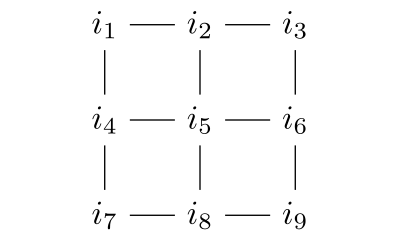

In [282]:
%%tikz -l graphdrawing,graphs,trees,automata,quotes,graphs.standard -f svg --save /Users/ivan/work/talks-online/eth-2015/2d.svg
\tikzset{>=stealth}
\usegdlibrary{layered,trees,circular,force}
\graph[grid placement]{subgraph Grid_n[V={$i_1$, $i_2$, $i_3$, $i_4$, $i_5$, $i_6$, $i_7$, $i_8$, $i_9$}] };

## 2D network
For many problems, the tree or train is not sufficient. For example, for 2D images you might think that a 2D network is appropriate.
<img src='2d.svg' width=40%>
Example of the 2D tensor network, 
in each node we have to store 5-dimensional tensor.

## Two-dimensional networks are hard
Even evaluation of an element  is an $\mathcal{O}(r^L)$ operation for an $L \times L$ network.

However, for the particular tensor, you may be able to compute efficiently using **approximate computations**.

## One of the ways to efficiency
We know a lot about efficient computations with **tensor train / tree formats**.

We can:
- Perform basic linear algebra operations (ranks increase during those)
- Multiply the tensors element-wise (ranks multiply)
- Do **recompression** (i.e. approximate a given tensor by another one will smaller ranks and error bounds)

## Tensor train

The TT-format 

$$A(i_1, \ldots, i_d) = G_1(i_1) \ldots G_d(i_d),$$

given the **ordering of the indices** can be characterized by the following condition:

$$\mathrm{rank}(A_k) = r_k,$$

where $A_k = A(i_1 i_2 \ldots i_k; i_{k+1} \ldots i_d)$ is the **k-th unfolding** of the tensor.

I.e. it is the **intersection of low-rank matrix manifolds**!

## Software
We have a TT-Toolbox, both in MATLAB http://github.com/oseledets/TT-Toolbox and in Python http://github.com/oseledets/ttpy 

for

- Computing the TT representation (i.e. checking if there is such a representation)
- Performing basic operations
- Adaptive sampling algorithms (cross approximation)
- Optimization algorithms 

In [25]:
# A short illustration
import numpy as np
import tt
from tt.cross import rect_cross as cross

d = 20
a = tt.ones(2, d)
b = a + a
#print b
#fun = lambda x: x.sum(axis=1)
#c = cross(fun, b)
#c.round(1e-8)

## Working with tensor networks using linear / tree networks

We have problems that can be efficiently solved using well-established NLA techniques, so it is a good idea to use that as **building blocks**.


Reduce these operations to operations with tensor trains, i.e. represent 2D network as a layer of 1D tensor networks!

## Practical example
<font size=6.5>
A Markov random field is another example of **tensor network**.
- Define an **undirected graph** $\mathcal{G}$ with nodes corresponding to the variables (pixels of the image).
- Define some positive functions $\Psi_c(T_c; X, W)$ (called MRF **factors**) on the cliques of the graph $\mathcal{G}$.
- The model is then defined as follows:
	$$
	p(T | X, W) = \frac{1}{Z(X, W)} \prod\limits_{c \in \mathcal{C}} \Psi_c(T_c; X, W),
	$$
	where $Z(X, W)$ is the normalization constant.

Even if the potentials are known, $Z(X, W)$ is difficult to compute (sum of a huge array).

## Representation as a product of low TT-rank tensors

Then, each factor depends only on the few variables, so its ranks are bounded.  

Thus, the tensor is a product of low-rank tensors

$$
   A = A_1 \circ A_2 \ldots \circ A_p,
$$

where $A_k(i_1, \ldots, i_d) = A_{k1}(i_1) \ldots A_{kd}(i_d)$.

Then, we use the standard trick and obtain
<font size=6.5>
$$\sum_{i_1, \ldots, i_d} A(i_1, \ldots, i_d) = \Big(\sum_{i_1} (A_{11}(i_1) \otimes A_{21}(i_1) \otimes \ldots \otimes A_{p1}(i_1)\Big)\ldots \Big(\sum_{i_1} (A_{11}(i_1) \otimes A_{2d}(i_d) \otimes \ldots \otimes A_{pd}(i_d)\Big),$$
</font>
i.e. is now **a product of small-rank tensors**, so we **multiply them  and compress**.

## Computing marginals
<font size=6.0>
One example from the paper by [Putting MRFs on a Tensor Train, A. Novikov, A. Rodomanov, A. Osokin, D. Vetrov, ICML-2014](https://www.dropbox.com/s/d479j6zocine232/Paper.pdf)
<img width=80% src='spinglass.svg'>
		$$\widehat{\mathbf{P}}(\vec{x}) = \prod_{i=1}^n \exp \left ( -\frac{1}{T} h_i x_i \right ) \prod_{(i, \, j) \in \mathcal{E}} \exp \left (-\frac{1}{T}c_{ij} x_i x_j \right )$$

Spin glass models, $T = 1$, $c_{ij} \sim U[-f, f]$.


## Summary 
- Tensor network is a convenient formalism
- Not all tensor networks are **easy**
- For some problem setups we can **recover the structure**
- We can use linear algebra tools for trees/trains
- We can use trees/trains to solve problems for more general tensor networks.

## Optimization problems with low-rank constaints
Even if there is no good low-rank approximation, low-rank tensor formats can be used as **regularizations** or **initial approximations**.

Given a certain functional $F(X)$, we restrict $X$ to the set of "low-rank" tensors $\mathcal{M}$, and minimize

$$F(X) \rightarrow \min, X \in \mathcal{M}$$

Usually in tensor community, alternating minimization is used

##Alternating optimization

Given $A(i_1, \ldots, i_d) = G_1(i_1) \ldots G_d(i_d)$ optimize over one core $G_k(i_k)$.  

- Good for **quadratic functionals**, and also you can parametrize     
    
    $$\mathrm{vec}(A) = Q \mathrm{vec}(G_k),$$  
    where $Q$ is orthonormal.
- Bad for non-quadratic (frequent in machine learning!)

Therefore, Riemanian optimization techniques are needed.

## Optimization methods on manifolds

For the low-rank manifold (matrix, TT, HT) we can efficiently compute the **projection** to the tangent space.


The simplest is to **project the gradient onto the tangent space:**

$$x_{k+1} = R(x_k + P_{\mathcal{T}}(\nabla F)), $$

where $R$ is the mapping from the tangent space to the manifold, called **retraction**.

## 2D case 
Just to give you the feeling, in two dimensions there is a simple formula.

$$X  = U S V^{\top},$$

$$P_X(Z) = Z - (I - UU^{\top}) Z (I - VV^{\top})$$

is the projection onto the tangent space.

For the multidimensional case, see [Time integration of tensor trains, C. Lubich, I. Oseledets, B. Vandereycken](http://arxiv.org/abs/1407.2042)

## Manifold optimization
- Problems with low-rank constraints can be solved efficiently using Riemannian optimization
- A good implementation does not require the full tensor to be stored.

## Example: all-subsets regression

Consider the binary classification problem. 

Log-regression is the simplest choice: given the **feature vector** $x$, 

we predict the probability to observe $y_i$

$$p = Z \exp(-y_i \langle w, x_i \rangle).$$

I.e. the predictor variable is just the linear combination of the components of the feature vector.

## All-subsets regression

We can use other predictor variable, for example, select product of features (subsets) like

$$w_1 x_1 + w_{125} x_1 x_2 x_5 + \ldots $$

We can code all **possible subsets** in this form by a vector of length $2^d$, or tensor of size $2 \times \ldots \times 2$.

(i.e. if there is $x_1$ in the term, or not). 

The predictor variable is then **$t = \langle W, X \rangle$**, where $\langle \cdot \rangle$ is the scalar product of tensors.

We impose low-rank constraints on the $W$, to avoid **overfitting**.

## Optimization problem

The total loss is the sum of individual losses

$$F(W) = \sum_{k=1}^K f(y_i, \langle X_i, W \rangle),$$

where $X_i$ is the low-rank tensor obtained from the **feature vector** $x_i$.

The gradient is easily computatble:

$$\nabla F = \sum_{k=1}^K \frac{df}{dz}(y_i, \langle X_i, W \rangle) X_i,$$

and **projection** onto the tangent space can be computed in a fast way.

## Preliminary results
On the problem [Otto](https://www.kaggle.com/c/otto-group-product-classification-challenge) from Kaggle, the larger the rank, the better is learning (still learning today)
<img src='all-subsets.svg'>

You have to train fast   
(GPU implementation is necessary, as in the Deep Learning).

## Low-rank factorization as initialization

You can use low-rank factorization to initialize other optimization methods.

We have successfully speeded up the convolutional neural networks by factorizing a 4D tensor into the canonical format and then **fine-tuning it**.

[Speeding-up Convolutional Neural Networks Using Fine-tuned CP-Decomposition
Vadim Lebedev, Yaroslav Ganin, Maksim Rakhuba, Ivan Oseledets, Victor Lempitsky, accepted at ICLR 2015](http://arxiv.org/abs/1412.6553)


## "Next level" multivariate functions representations

- Are based on the composition of "simple" functions (product, sums)
- **Proposal**: consider superposition of low-rank functions.
- Require fast solvers for low-rank constained optimization problems

## Example: quantization

Introduced by Oseledets for matrices and Khoromskij for vectors,  the idea of **quantization** is very powerful:

Given a univariate function $f(x)$ on a uniform grid with $2^d$ points, reshape it into $2 \times \ldots \times 2$  

$d$-dimensional tensor and apply **TT-decomposition to it**. The is the **QTT** decomposition.

It gives **logarithmic complexity** in the number of samples.

## Demo
Consider the function $f(x, y) = \frac{\exp(i k r)}{r}, r = \sqrt{x^2 + y^2}$ on a uniform grid in $[\delta, 1]^2$ with the quantization  
in **Cartesian coordinates**.

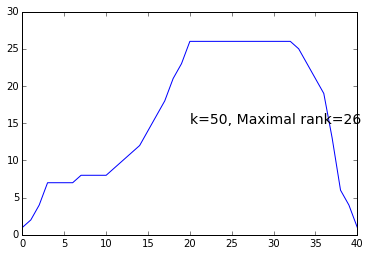

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import tt
import numpy as np
k = 50
delta = 1e-2
d = 20 
n = 2 ** d
t = np.linspace(delta, 1, n)
t = np.reshape(t, [2] * d, "F")
t_ten = tt.tensor(t, eps=1e-10)
e = tt.ones(2, d)
x = tt.kron(t_ten, e)
y = tt.kron(e, t_ten)
my_fun = lambda x: np.exp(-1j * k * np.sqrt(x[:, 0] ** 2 + x[:, 1] ** 2))/(np.sqrt(x[:, 0] ** 2 + x[:, 1] ** 2))
z = tt.multifuncrs([x, y], my_fun, eps=1e-6, verb=False)
plt.plot(z.r)
plt.text(0.5, 0.5, 'k=%d, Maximal rank=%d' % (k, max(z.r)),  fontsize=14, transform=plt.gca().transAxes)

## polar  coordinates

$$x = r \cos \varphi, \quad y = r \cos \varphi, \quad f(r) = \frac{\exp(ikr)}{r}$$

## Example: active subspaces

Given a function $f(x_1, \ldots, x_d)$ we try reparametrize the variable $x$ into a new variable $t$ by a **linear transformation**  

$$x = W t.$$

A natural way to go is to align the axis with the directions where the function **varies the most**:

1. Compute the covariance matrix of the gradients $C = E(\nabla f \nabla f^{\top})$
2. Compute the  eigenvectors $W$ of  $C_x$

This can significantly improve the separability!

## Some examples.
1. If the function $f$ is a functions of a fewer linear combinations of original variables, then $C_x$ will be not of full rank.
2. Gaussian function $\exp({-x^{\top} A x})$ is rotated into the product form!

## Practical example from chemistry
We have considered the potential energy surface of the water molecule in the Cartesian coordinates.  

It has 9 dimensions, and active subspace rotation significantly reduces the ranks.

<img width=80% src='cheb_table.svg'>

## Is it possible to learn the network structure?

The main problems are:
- How to select the network structure in the appropriate way?
- How to learn the parameters (i.e., tensors living in each vertex) of the network, once you know its structure.
- Learn the parameters very well with linear structures (and tensor trains) and also with tree structure (and H-Tucker). 

## MMMA-2015
In August 23-28 2015 we hold the **4-th Moscow conference in Matrix Methods in Mathematics and Applications**.  

Confirmed speakers: C. Schwab, J. White, D. Zorin, M. Benzi, P.-A.Absil, A. Cichocki, P. Van Dooren.

**Good time to visit Moscow** (i.e., due to the exchange rate drop from 35 roubles/dollar to 51 roubles/dollar). 



http://matrix.inm.ras.ru/mmma-2015/

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()